## Homework

> Note: sometimes your answer doesn't match one of 
> the options exactly. That's fine. 
> Select the option that's closest to your solution.

### Dataset

In this homework, we will use the Students Performance in 2024 JAMB dataset from [Kaggle](https://www.kaggle.com/datasets/idowuadamo/students-performance-in-2024-jamb).

Here's a wget-able [link](https://github.com/alexeygrigorev/datasets/raw/refs/heads/master/jamb_exam_results.csv):

In [ ]:
!wget https://github.com/alexeygrigorev/datasets/raw/refs/heads/master/jamb_exam_results.csv


The goal of this homework is to create a regression model for predicting the performance of students on a standardized test (column `'JAMB_Score'`).

### Preparing the dataset 

First, let's make the names lowercase:

```python
df.columns = df.columns.str.lower().str.replace(' ', '_')
```

Preparation:

* Remove the `student_id` column.
* Fill missing values with zeros.
* Do train/validation/test split with 60%/20%/20% distribution. 
* Use the `train_test_split` function and set the `random_state` parameter to 1.
* Use `DictVectorizer(sparse=True)` to turn the dataframes into matrices.

In [ ]:
import pandas as pd

df = pd.read_csv("jamb_exam_results.csv")
df.columns = df.columns.str.lower().str.replace(' ', '_')

df.head()

In [3]:
df = df.drop(columns='student_id')
df = df.fillna(0)

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer


X = df.drop(columns='jamb_score')
y = df['jamb_score']

X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=1)

dv = DictVectorizer(sparse=True)
X_train = dv.fit_transform(X_train.to_dict(orient='records'))
X_val = dv.transform(X_val.to_dict(orient='records'))
X_test = dv.transform(X_test.to_dict(orient='records'))

## Question 1

Let's train a decision tree regressor to predict the `jamb_score` variable. 

* Train a model with `max_depth=1`.


Which feature is used for splitting the data?

* `study_hours_per_week`
* `attendance_rate`
* `teacher_quality`
* `distance_to_school`

In [5]:
from sklearn.tree import DecisionTreeRegressor, export_text

dt = DecisionTreeRegressor(max_depth=1)
dt.fit(X_train, y_train)
print(export_text(dt, feature_names=list(dv.get_feature_names_out())))

|--- study_hours_per_week <= 18.50
|   |--- value: [155.24]
|--- study_hours_per_week >  18.50
|   |--- value: [188.59]



## Question 2

Train a random forest regressor with these parameters:

* `n_estimators=10`
* `random_state=1`
* `n_jobs=-1` (optional - to make training faster)


What's the RMSE of this model on the validation data?

* 22.13
* 42.13
* 62.13
* 82.12


In [6]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error


rf_model = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=-1)
rf_model.fit(X_train, y_train)

y_val_pred = rf_model.predict(X_val)

rmse = root_mean_squared_error(
    y_val, y_val_pred
)
print(f"RMSE: {rmse}")


RMSE: 42.13724207871227


## Question 3

Now let's experiment with the `n_estimators` parameter

* Try different values of this parameter from 10 to 200 with step 10.
* Set `random_state` to `1`.
* Evaluate the model on the validation dataset.


After which value of `n_estimators` does RMSE stop improving?
Consider 3 decimal places for calculating the answer.

- 10
- 25
- 80
- 200

R/ 80

<Axes: xlabel='n_estimators'>

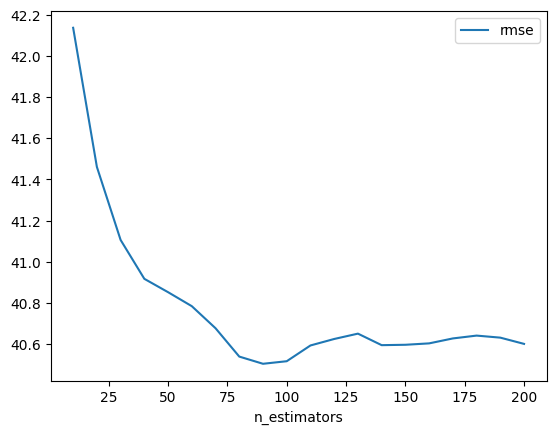

In [7]:
import numpy as np


n_estimators_list = np.arange(10, 201, 10)
scores_list = []

for i in n_estimators_list:

    rf_model = RandomForestRegressor(n_estimators=i, random_state=1, n_jobs=-1)
    rf_model.fit(X_train, y_train)

    y_val_pred = rf_model.predict(X_val)

    rmse = root_mean_squared_error(
        y_val, y_val_pred
    )

    scores_list.append((i, rmse))


df_scores = pd.DataFrame(scores_list, columns=['n_estimators', 'rmse'])
df_scores.plot(x='n_estimators', y='rmse')


## Question 4

Let's select the best `max_depth`:

* Try different values of `max_depth`: `[10, 15, 20, 25]`
* For each of these values,
  * try different values of `n_estimators` from 10 till 200 (with step 10)
  * calculate the mean RMSE 
* Fix the random seed: `random_state=1`


What's the best `max_depth`, using the mean RMSE?

* 10
* 15
* 20
* 25

R/ 10

In [8]:
import numpy as np


n_estimators_list = np.arange(10, 201, 10)
max_depth_list = [10, 15, 20, 25]
scores_list = []

for n_est in n_estimators_list:
    for max_d in max_depth_list:

        rf_model = RandomForestRegressor(n_estimators=n_est, max_depth=max_d, random_state=1, n_jobs=-1)
        rf_model.fit(X_train, y_train)

        y_val_pred = rf_model.predict(X_val)

        rmse = root_mean_squared_error(
            y_val, y_val_pred
        )

        scores_list.append((n_est, rmse, max_d))


df_scores = pd.DataFrame(scores_list, columns=['n_estimators', 'rmse', 'max_depth'])


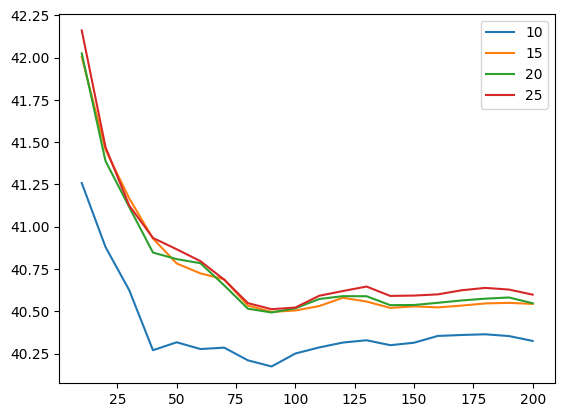

In [9]:
from matplotlib import pyplot as plt

for d in [10, 15, 20, 25]:
    df_subset = df_scores[df_scores.max_depth == d]
    plt.plot(df_subset.n_estimators, df_subset.rmse, label=d)

plt.legend()
plt.show()

# Question 5

We can extract feature importance information from tree-based models. 

At each step of the decision tree learning algorithm, it finds the best split. 
When doing it, we can calculate "gain" - the reduction in impurity before and after the split. 
This gain is quite useful in understanding what are the important features for tree-based models.

In Scikit-Learn, tree-based models contain this information in the
[`feature_importances_`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor.feature_importances_)
field. 

For this homework question, we'll find the most important feature:

* Train the model with these parameters:
  * `n_estimators=10`,
  * `max_depth=20`,
  * `random_state=1`,
  * `n_jobs=-1` (optional)
* Get the feature importance information from this model


What's the most important feature (among these 4)? 

* `study_hours_per_week`
* `attendance_rate`
* `distance_to_school`
* `teacher_quality`


In [10]:
rf_model = RandomForestRegressor(n_estimators=10, max_depth=10, random_state=1, n_jobs=-1)
rf_model.fit(X_train, y_train)

y_val_pred = rf_model.predict(X_val)

rf_model.feature_importances_


array([0.00960322, 0.00876561, 0.06056468, 0.02747828, 0.15429737,
       0.12298216, 0.0079326 , 0.01017526, 0.00698562, 0.00846525,
       0.01860258, 0.00935373, 0.0070402 , 0.        , 0.01289089,
       0.0139241 , 0.0125016 , 0.02471051, 0.01234667, 0.0104377 ,
       0.00800823, 0.00687182, 0.00627532, 0.00742991, 0.03170903,
       0.00954657, 0.00762981, 0.28497328, 0.09849798])

In [38]:
df_importances = pd.DataFrame()
df_importances['feature'] = dv.feature_names_
df_importances['importance'] = rf_model.feature_importances_
df_importances.sort_values(by='importance', ascending=False)


,feature,importance
27,study_hours_per_week,0.284973
4,attendance_rate,0.154297
5,distance_to_school,0.122982
28,teacher_quality,0.098498
2,age,0.060565
24,socioeconomic_status=High,0.031709
3,assignments_completed,0.027478
17,parent_involvement=High,0.024711
10,it_knowledge=High,0.018603
15,parent_education_level=Secondary,0.013924


## Question 6

Now let's train an XGBoost model! For this question, we'll tune the `eta` parameter:

* Install XGBoost
* Create DMatrix for train and validation
* Create a watchlist
* Train a model with these parameters for 100 rounds:

```python
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}
```

Now change `eta` from `0.3` to `0.1`.

Which eta leads to the best RMSE score on the validation dataset?

* 0.3
* 0.1
* Both give equal value


In [15]:
import xgboost as xgb


In [16]:
xgb_params = {
    'eta': 0.3,
    'max_depth': 6,
    'min_child_weight': 1,
    'objective': 'reg:squarederror',
    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

In [23]:
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=dv.feature_names_)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=dv.feature_names_)

watchlist = [(dtrain, 'train'), (dval, 'val')]


In [ ]:
def parse_xgb_output(output):
    results = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        results.append((it, train, val))

    columns = ['num_iter', 'train_auc', 'val_auc']
    df_results = pd.DataFrame(results, columns=columns)
    return df_results

In [30]:
model = xgb.train(
    xgb_params,
    dtrain=dtrain,
    num_boost_round=100,
    verbose_eval=5,
    evals=watchlist
)


[0]	train-rmse:42.69384	val-rmse:44.89114
[5]	train-rmse:34.57756	val-rmse:40.69096
[10]	train-rmse:31.63404	val-rmse:40.48319
[15]	train-rmse:29.41497	val-rmse:40.86107
[20]	train-rmse:27.49658	val-rmse:41.27921
[25]	train-rmse:26.34353	val-rmse:41.57975
[30]	train-rmse:24.21076	val-rmse:41.72928
[35]	train-rmse:22.46394	val-rmse:42.03417
[40]	train-rmse:21.35340	val-rmse:42.24363
[45]	train-rmse:20.24355	val-rmse:42.27966
[50]	train-rmse:19.25157	val-rmse:42.43824
[55]	train-rmse:18.28398	val-rmse:42.54750
[60]	train-rmse:17.12178	val-rmse:42.64446
[65]	train-rmse:16.41573	val-rmse:42.77416
[70]	train-rmse:15.78314	val-rmse:42.84909
[75]	train-rmse:14.80007	val-rmse:43.00760
[80]	train-rmse:13.96907	val-rmse:43.08250
[85]	train-rmse:13.39102	val-rmse:43.16297
[90]	train-rmse:12.46485	val-rmse:43.25161
[95]	train-rmse:11.95568	val-rmse:43.37919
[99]	train-rmse:11.39140	val-rmse:43.41882


In [36]:
xgb_params = {
    'eta': 0.1,
    'max_depth': 6,
    'min_child_weight': 1,
    'objective': 'reg:squarederror',
    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(
    xgb_params,
    dtrain=dtrain,
    num_boost_round=100,
    verbose_eval=5,
    evals=watchlist
)


[0]	train-rmse:45.49999	val-rmse:47.00533
[5]	train-rmse:40.17514	val-rmse:43.11181
[10]	train-rmse:37.07490	val-rmse:41.39235
[15]	train-rmse:35.08521	val-rmse:40.61341
[20]	train-rmse:33.67389	val-rmse:40.25010
[25]	train-rmse:32.55850	val-rmse:40.12003
[30]	train-rmse:31.76039	val-rmse:40.13806
[35]	train-rmse:31.01425	val-rmse:40.16103
[40]	train-rmse:30.13427	val-rmse:40.17753
[45]	train-rmse:29.49040	val-rmse:40.27366
[50]	train-rmse:28.75947	val-rmse:40.29573
[55]	train-rmse:28.17535	val-rmse:40.40072
[60]	train-rmse:27.77264	val-rmse:40.47477
[65]	train-rmse:27.10119	val-rmse:40.47659
[70]	train-rmse:26.61847	val-rmse:40.55225
[75]	train-rmse:26.21281	val-rmse:40.62564
[80]	train-rmse:25.69135	val-rmse:40.61309
[85]	train-rmse:25.14363	val-rmse:40.66530
[90]	train-rmse:24.60413	val-rmse:40.84708
[95]	train-rmse:24.03404	val-rmse:40.99952
[99]	train-rmse:23.59704	val-rmse:41.05034


## Submit the results

* Submit your results here: https://courses.datatalks.club/ml-zoomcamp-2024/homework/hw06
* If your answer doesn't match options exactly, select the closest one
